In [45]:
from mechanical_regression import MechanicalRegression
from vizual import loss_plot, alpha1_plot 
import torch
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
import tensorflow as tf

In [3]:
def experiments(pb_type, L, activ, train_data_dict, test_data, D1, D2, p, nsteps=1000, lr=0.1):
    '''results for fixed activation function and number of layers L'''
    alpha1_energy, train_l2_reg_loss, train_error, test_error = {}, {}, {}, {}
    model = MechanicalRegression(pb_type, L, activ, D1, D2, p)
    x_test, y_test = test_data
    for N in train_data_dict:
        x_train, y_train = train_data_dict[N]
        alpha1 = model.fit(x_train, y_train, nsteps=nsteps, lr=lr) 
        if L > 0:
            alpha1_energy[N] = (1/L)*torch.sum(alpha1 * alpha1)
        else:
            alpha1_energy[N] = torch.sum(alpha1 * alpha1)
        train_l2_reg_loss[N] = model.get_loss(x_train, y_train, alpha1)
        train_error[N] =  model.get_error(x_train, y_train)                      
        test_error[N] = model.get_error(x_test, y_test)

    return alpha1_energy, train_l2_reg_loss, train_error, test_error

# Regression data

## Synthetic dataset

In [4]:
def get_data_train(n, sigma=3):
    """Train data for regression with synthetic dataset"""
    np.random.seed(111)
    x = (np.linspace(-5, 5, n))[..., np.newaxis]
    noise = np.random.normal(scale=sigma, size=(n, 1))
    y = x**2 + x + noise
    return torch.from_numpy(x), torch.from_numpy(y)


def get_data_test(n, sigma=3):
    """Test data for regression with synthetic dataset"""
    x = (np.linspace(-5, 5, n) + 0.5/n)[..., np.newaxis]
    y = x**2 + x + np.random.normal(scale=sigma, size=(n, 1))
    return torch.from_numpy(x), torch.from_numpy(y)

In [14]:
test_data = get_data_test(200)

N_list = [50, 100, 200, 400, 800, 1600, 3200, 6400] 
data_dict = {N: get_data_train(N) for N in N_list}

activations = ['ReLU', 'tanh', 'sigmoid']
Layers = [0, 2, 4, 6, 8]
pb_type = 'regression'
metric_names = ['alpha1_energy', 'l2_reg_loss', 'train_error', 'test_error']
p = 1
D1 = 1
D2 = 10
nsteps = 500 
lr = 0.01


def experiments_dict(pb_type, activations, Layers, data_dict, test_data, D1, D2, p, nsteps, lr):
    results = {}
    for activ in activations:
        results[activ] = {}
        for L in Layers:
            res = experiments(pb_type=pb_type, L=L, activ=activ, train_data_dict=data_dict, test_data=test_data,
                              D1=D1, D2=D2, p=p, nsteps=nsteps, lr=lr)
            results[activ][L] = {name: metric for name, metric in zip(metric_names, res)}
    return results
      
results_synt = experiments_dict(pb_type, activations, Layers, data_dict, test_data, D1, D2, p, nsteps, lr)

[500]

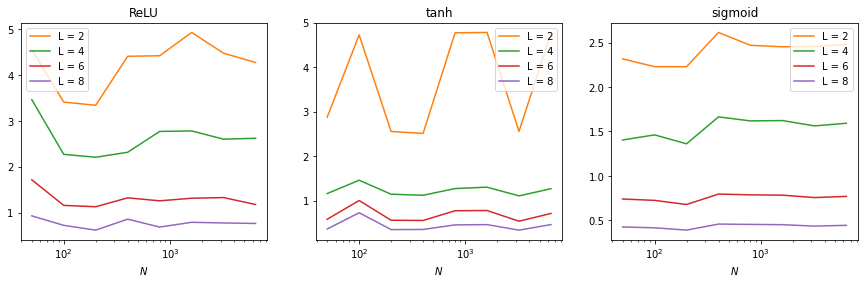

In [15]:
alpha1_plot(results_synt, log_scale_x=True)

In [10]:
#for activ in activations:
#    loss_plot(results_synt[activ], log_scale_x=True)

## Boston Housing dataset

In [61]:
def get_data_split(X, y, test_size):
    """Dataset split into train/test"""
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    y_train, y_test = y_train[..., np.newaxis], y_test[..., np.newaxis]
    return torch.tensor(x_train), torch.tensor(x_test), torch.tensor(y_train), torch.tensor(y_test)

def get_data_dict(X, y, R=np.arange(0.1, 1.1, 0.1), split=True, train_size = 0.8):
    """Data dictionary for experiments"""
    if split:
        x_train, x_test, y_train, y_test = get_data_split(X, y, test_size=1-train_size)
    else:
        x_train, y_train = X, y
    N_train = len(x_train)
    data_train_dict = {}
    for r in R:
        N = np.int(r * N_train)
        x, y = x_train[0:N], y_train[0:N]
        data_train_dict[N] = (x, y)
    if split:    
        return data_train_dict, (x_test, y_test)
    else:
        return data_train_dict

In [34]:
Xboston, yboston = load_boston(return_X_y = True)
boston_train_data_dict, boston_test_data = get_data_dict(Xboston, yboston)

D1 = Xboston.shape[1]
p = Xboston.shape[1]
D2 = 10*D1

boston_results = experiments_dict(pb_type, activations, Layers, boston_train_data_dict, 
                                  boston_test_data, D1, D2, p, nsteps, lr)

[500]

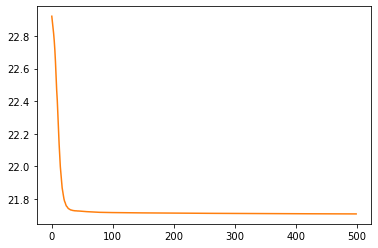

In [37]:
plt.plot(model.loss_history)

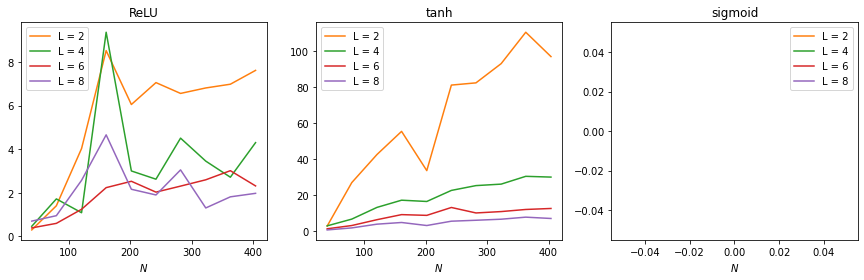

In [42]:
alpha1_plot(boston_results)#, log_scale_x=True)

# Classification 

In [68]:
def load_data(loadmnist):
    Ntrain = 50000
    Ntest = 10000
    if loadmnist:
        mnist = tf.keras.datasets.mnist
        class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    else:
        mnist = tf.keras.datasets.fashion_mnist
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train.astype('float64'), x_test.astype('float64')
    x_train, y_train = x_train[0:Ntrain,:,:], y_train[0:Ntrain]
    x_test, y_test = x_test[0:Ntest,:,:], y_test[0:Ntest]
    
    # get one-hot vectors 
    Y_train = np.zeros((Ntrain,10))
    Y_test = np.zeros((Ntest,10))
    for i in range(10):
        Y_train[y_train[0:Ntrain] == i,i] = 1
        Y_test[y_test[0:Ntest] == i,i] = 1
    
    x_train, x_test = x_train / 255.0, x_test / 255.0
    normalizedata = False
    if normalizedata:
        a = np.sqrt(np.sum(x_train*x_train,(1,2)))
        a = a[:,None,None]+np.zeros((Ntrain,28,28))
        x_train = np.divide(x_train , a)
        a = np.sqrt(np.sum(x_test*x_test,(1,2)))
        a = a[:,None,None]+np.zeros((Ntest,28,28))
        x_test = np.divide(x_test , a)
        a = 0  
    d2 = 28*28
    x_train, x_test = np.reshape(x_train, (Ntrain, d2)), np.reshape(x_test, (Ntest, d2))
    
    x_train = torch.tensor(x_train.astype('float64'))
    x_test = torch.tensor(x_test.astype('float64'))
    Y_train = torch.tensor(Y_train.astype('float64'))
    Y_test = torch.tensor(Y_test.astype('float64'))
    
    return (x_train, Y_train), (x_test, Y_test)

(X, y), mnist_test_data = load_data(loadmnist=True)
mnist_data_dict = get_data_dict(X, y, R=np.arange(0.01, 0.11, 0.01), split=False)

In [91]:
x_train, y_train = mnist_data_dict[list(mnist_data_dict.keys())[-1]]

p = x_test.shape[1]
D1 = p
D2 = 10

model = MechanicalRegression(pb_type, 2, 'relu', D1, D2, p)
alpha1 = model.fit(x_train, y_train, nsteps=100, lr=0.001)

[100]

In [92]:
torch.sum(alpha1**2)

tensor(0.7670, dtype=torch.float64)

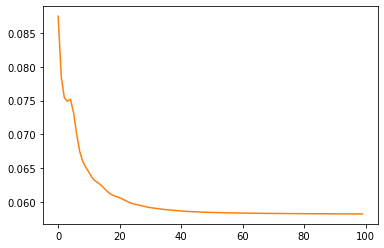

In [93]:
plt.plot(model.loss_history)

In [95]:
print(model.get_error(x_test, y_test))
print(model.get_error(x_train, y_train))

tensor(0.0467, dtype=torch.float64)
tensor(0.0440, dtype=torch.float64)


In [44]:
pb_type = 'classification'
Layers = [0, 1, 2, 3]
p = x_test.shape[1]
D1 = p
D2 = p

mnist_results = experiments_dict(pb_type, activations, Layers, mnist_data_dict, mnist_test_data, 
                                 D1, D2, p, nsteps, lr)

NameError: name 'tf' is not defined

## Fashion MNIST

In [98]:
(X, y), mnist_fash_test_data = load_data(loadmnist=False)
mnist_fash_data_dict = get_data_dict(X, y, R=np.arange(0.01, 0.11, 0.01), split=False)

In [157]:
x_train, y_train = mnist_fash_data_dict[list(mnist_fash_data_dict.keys())[-1]]

p = x_test.shape[1]
D1 = p
D2 = 10

model = MechanicalRegression(pb_type, 0, 'relu', D1, D2, p)
alpha1 = model.fit(x_train, y_train, nsteps=60, lr=0.001)

In [158]:
model.alpha2_opt.shape

torch.Size([10, 10])

In [159]:
#plt.plot(model.loss_history)
print(model.get_error(x_test, y_test))
print(model.get_error(x_train, y_train))

tensor(0.1117, dtype=torch.float64)
tensor(0.0707, dtype=torch.float64)


In [ ]:
pb_type = 'classification'
Layers = [0, 1, 2, 3]
p = x_test.shape[1]
D1 = p
D2 = p

mnist_fash_results = experiments_dict(pb_type, activations, Layers, mnist_fash_data_dict, mnist_fash_test_data, 
                                  D1, D2, p, nsteps, lr)

